In [1]:
from leicaautomator.automator import find_spots
from leicaautomator.utils import save_regions, flatten
from leicaexperiment import Experiment
from leicascanningtemplate import ScanningTemplate
from leicacam import CAM

In [2]:
exp_path = r"D:\MatrixScreenerImages\3.3.0_9757\ ".strip()
exp_path

'D:\\MatrixScreenerImages\\3.3.0_9757\\'

In [3]:
cam = CAM()

In [4]:
cam.load_template('leicaautomator-overview')

OrderedDict([('cli', 'python-leicacam'), ('app', 'matrix'), ('sys', '0'), ('cmd', 'load'), ('fil', '{ScanningTemplate}leicaautomator-overview')])

In [6]:
44961.38-39746.25

5215.129999999997

In [8]:
(84511.65-75020.19) / 1050

9.039485714285707

In [12]:
cam.wait_for('relpath')

OrderedDict([('relpath', '\\3.3.0_9757\\experiment--2015_04_19_10_39_43\\slide--S00\\chamber--U00--V00\\field--X03--Y00\\image--L0000--S00--U00--V00--J08--E00--O00--X03--Y00--T0000--Z00--C00.ome.tif'), ('jobname', 'Job 2')])

In [20]:
whole = _12['relpath'].split('\\')[2]
experiment = Experiment(exp_path + whole)

In [21]:
!dir $experiment.path

 Volume in drive D is DATADRIVE1
 Volume Serial Number is F805-2E08

 Directory of D:\MatrixScreenerImages\3.3.0_9757\experiment--2015_04_19_10_39_43

04/19/2015  12:39 PM    <DIR>          .
04/19/2015  12:39 PM    <DIR>          ..
04/19/2015  12:39 PM    <DIR>          AdditionalData
04/19/2015  12:39 PM    <DIR>          slide--S00
               0 File(s)              0 bytes
               4 Dir(s)  1,664,438,173,696 bytes free


In [15]:
cam.wait_for('inf', 'scanfinished')

OrderedDict([('app', 'matrix'), ('sys', '0'), ('inf', 'scanfinished')])

# compress and rotate images

In [22]:
compressed = experiment.compress(delete_tif=True)
assert len(compressed) == len(experiment.images)
from PIL import Image
for img in experiment.images:
    i = Image.open(img)
    i = i.rotate(270)
    i.save(img)

In [23]:
experiment.stitch()

['D:\\MatrixScreenerImages\\3.3.0_9757\\experiment--2015_04_19_10_39_43\\stitched--U00--V00--C00--Z00.png']

In [24]:
regions = find_spots(experiment)

Well distance x in microns: 1717.27066104
Well distance y in microns: 1695.83384295
Well offsets
( well )   x[um], y[um]
-----------------------
( 0,  1)    -209,   -35
( 0,  2)     -75,   112
( 1,  0)     169,   -20
( 1,  2)      57,  -109
( 1,  3)    -134,  -119
( 1,  4)    -163,  -120
( 1,  5)    -159,  -187
( 1,  6)      98,  -108
( 1,  7)      19,   -50
( 1,  8)      50,  -154
( 2,  0)      48,  -152
( 2,  1)      58,  -213
( 2,  2)     -43,  -193
( 2,  3)     -13,  -133
( 2,  4)     -61,  -145
( 2,  5)     -20,  -178
( 2,  6)     119,  -122
( 2,  7)     185,    -7
( 2,  8)      98,  -138
( 3,  0)       6,  -184
( 3,  1)       5,  -219
( 3,  2)     -29,  -291
( 3,  3)    -202,  -312
( 3,  4)    -167,  -257
( 3,  5)    -172,  -192
( 3,  6)     -47,  -133
( 3,  7)     -31,  -139
( 3,  8)     124,  -197
( 4,  0)     -81,  -250
( 4,  1)     -28,  -199
( 4,  3)    -110,  -369
( 4,  4)     -92,  -343
( 4,  5)     -24,   -55
( 4,  6)      -1,   -63
( 4,  7)      56,   -30
( 4,  8)      8

In [26]:
labels, regions = regions

In [27]:
%matplotlib inline
from skimage import io

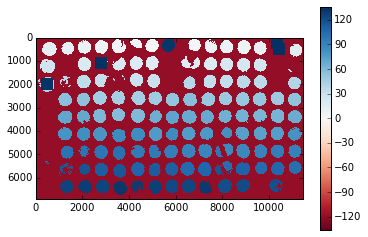

In [30]:
labels[labels == -1] = -120
io.imshow(labels);

In [31]:
save_regions(regions, exp_path + whole + r'\regions.json')

TypeError: 133 is not JSON serializable

In [33]:
import pickle

In [39]:
with open('regions.pickle', 'wb') as f:
    pickle.dump(regions, f)

In [40]:
tmpl_path = r"C:\Users\TCS-User\AppData\Roaming\Leica Microsystems\LAS X\MatrixScreener\ScanningTemplates\ ".strip()

In [49]:
i=3
region = regions[i]

In [58]:
region.well_x, region.well_y, region.real_x *1e6//1, region.real_y *1e6 //1, region.bbox

(1, 0, 61737.0, 30998.0, (198, 1086, 755, 1627))

In [59]:
metadata = experiment.field_metadata()
px_size = float(metadata.Image.Pixels.attrib['PhysicalSizeX'])*1e-6

In [61]:
y,x,yy,xx = region.bbox

In [67]:
y_size, x_size = px_size*(yy-y)*1e6, px_size*(xx-x)*1e6

In [51]:
tmpl_name = '{ScanningTemplate}leicaautomator'
tmpl = ScanningTemplate(tmpl_path + tmpl_name + str(i%2) + '.xml')

In [73]:
from math import ceil
y_fields = ceil(y_size / tmpl.properties.ScanFieldStageDistanceX)
x_fields = ceil(x_size / tmpl.properties.ScanFieldStageDistanceX)
y_fields, x_fields

(6, 6)

In [74]:
# disable all
for f in tmpl.fields:
    f.attrib['Enabled'] = 'false'

In [78]:
# enable fields
for y in range(y_fields):
    for x in range(x_fields):
        # off by one
        tmpl.field(field_y=y+1, field_x=x+1).attrib['Enabled'] = 'true'

In [79]:
tmpl.move_well(1,1,region.real_x, region.real_y)

In [80]:
tmpl.write()

- ** enable MP shutter **

- ** X Position on USB Control Panel -- 0-max -- CRASH! **

In [94]:
x = cam.get_information()['xpos']

In [95]:
y = cam.get_information()['ypos']

In [96]:
x, y

('0.0605274934', '0.031327772')

well has moved :-(

** try restart **